In [169]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tqdm import tqdm, trange
import pickle
import seaborn as sns
DEVICE = torch.device("cpu")

100%|██████████| 114/114 [00:00<00:00, 243.36it/s]


(DefaultActor pid=32129)  Training loss for epoch 2: 1.2300354132526798, accuracy: 0.5614035087719298


In [140]:
with open('./data/classification_data.pkl', 'rb') as f:
            data = pickle.load(f)

In [141]:
l2idx = {l:i for i, l in enumerate(set([y for _, y in data['Consumer1']]))}

In [163]:
l2idx

{'Kettle': 0,
 'Lighting': 1,
 'Refrigerator': 2,
 'Water heater': 3,
 'Washing Machine': 4,
 'Microwave': 5,
 'TV': 6,
 'Dryer': 7,
 'AC': 8,
 'Dish washer': 9}

In [142]:
class ClassificationData(Dataset):
    def __init__(self, data):
        self.x = [x for x, _ in data]
        self.Y = [y for _, y in data]
        self.l2idx = l2idx
        self.idx2l = {i:l for l, i in l2idx.items()}
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, i):
        return torch.tensor(self.x[i], dtype=torch.float), torch.tensor(self.l2idx[self.Y[i]], dtype=torch.long)

In [143]:
data_plus = []
for consumer in data:
    data_plus += data[consumer]

In [144]:
train_data = ClassificationData(data_plus)

In [145]:
class MultiToOneRNN(nn.Module):
    def __init__(self, hidden_size, num_layers=1, output_size=10, LSTM=False, bidirectional=False):
        super(MultiToOneRNN, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = LSTM
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.directions = 1 if not self.bidirectional else 2
        if LSTM:
            self.rnn = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        else:
            self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
            
        self.fc1 = nn.Linear(self.hidden_size*self.directions, hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, inputs, hidden_state, cell=None):
        if self.LSTM:
            output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        else:
            output, hidden_states = self.rnn(inputs, hidden_state)
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden_states, cell

In [146]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

In [196]:
epochs = 1
def train(net, train_loader):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    num_layers = net.num_layers
    batch_size = train_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    for epoch in range(epochs):
        net.train()
        total_loss = 0.0
        golds = []
        preds = []
        for x, Y in tqdm(train_loader):
            Y = Y.to(DEVICE)
            x = x.to(DEVICE).view(batch_size, -1, 1)
            hidden = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            loss = criterion(outs[:, -1], Y)    
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
            preds += pred.tolist()
            golds += Y.tolist()
            optimizer.zero_grad()
        val_losses.append(total_loss / len(train_loader))
        acc = np.mean((np.array(golds) == np.array(preds)))
        print(f' Training loss for epoch {epoch}: {total_loss / len(train_loader)}, accuracy: {acc}')
       
    return val_losses

# Non-Federated learning (Try to just fit the train set)

In [197]:
model = MultiToOneRNN(64, LSTM=False, bidirectional=True).to(DEVICE)

In [102]:
losses = train(model, train_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.15it/s]


 Training loss for epoch 0: 2.094950842077711, accuracy: 0.21343556002448194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 150.81it/s]


 Training loss for epoch 1: 1.607715711181289, accuracy: 0.38457418903558627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:16<00:00, 150.19it/s]


 Training loss for epoch 2: 1.7438761805429048, accuracy: 0.3480097490600682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.16it/s]


 Training loss for epoch 3: 1.6623926477185431, accuracy: 0.37561204861414704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11437/11437 [01:15<00:00, 151.03it/s]


 Training loss for epoch 4: 1.8979691659340003, accuracy: 0.28338397306986096


  4%|███████████▊                                                                                                                                                                                                                                                                        | 487/11437 [00:03<01:13, 149.85it/s]


KeyboardInterrupt: 

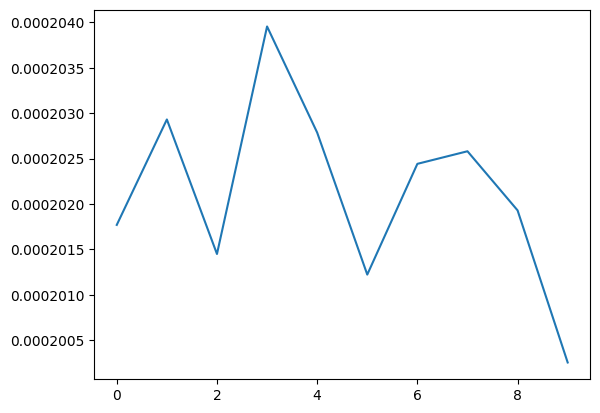

In [103]:
plt.plot(losses)

# Federated learning

In [165]:
batch_size = 32
hidden_size = 64
learning_rate = 3e-4

In [166]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [204]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': np.mean(loss)}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MultiToOneRNN(hidden_size=hidden_size).to(DEVICE)
    d = ClassificationData(data[f'Consumer{cid}'])
    train_loader = DataLoader(d, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader)


class SaveModelStrategy(fl.server.strategy.FedAvgM):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MultiToOneRNN(hidden_size=hidden_size).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...", flush=True)

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")
            print(f"Saved round {server_round} aggregated_parameters!", flush=True)


        return aggregated_parameters, aggregated_metrics

def agg(metrics):
    losses = np.mean([m[-1]["loss"] for m in metrics])
    return {'losses': losses}



In [ ]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=0.25,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=0,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
    fit_metrics_aggregation_fn= agg
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
res = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-03 09:57:47,769 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-03 09:57:51,252	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2023-11-03 09:57:51,816 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8269678183.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8269678183.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-11-03 09:57:51,816 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-03 09:57:51,817 | app.py:224 | Flower VCE: Resources for each Virtual Client

(DefaultActor pid=32839)  Training loss for epoch 0: 2.304221508795755, accuracy: 0.09402412280701754


100%|██████████| 114/114 [00:00<00:00, 188.52it/s] [repeated 2x across cluster]


(DefaultActor pid=32835)  Training loss for epoch 0: 2.3047475814819336, accuracy: 0.09649122807017543 [repeated 6x across cluster]


DEBUG flwr 2023-11-03 09:58:04,848 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


Saving round 1 aggregated_parameters...
Saved round 1 aggregated_parameters!


INFO flwr 2023-11-03 09:58:04,859 | server.py:171 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
DEBUG flwr 2023-11-03 09:58:04,860 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 40)
100%|██████████| 114/114 [00:00<00:00, 189.15it/s] [repeated 4x across cluster]


(DefaultActor pid=32837)  Training loss for epoch 0: 2.3004762938148096, accuracy: 0.10581140350877193 [repeated 5x across cluster]


100%|██████████| 114/114 [00:00<00:00, 238.74it/s] [repeated 3x across cluster]


(DefaultActor pid=32838)  Training loss for epoch 0: 2.298591456915203, accuracy: 0.11074561403508772 [repeated 3x across cluster]


100%|██████████| 114/114 [00:00<00:00, 214.38it/s] [repeated 2x across cluster]


(DefaultActor pid=32833)  Training loss for epoch 0: 2.3005646048930655, accuracy: 0.1137609649122807 [repeated 3x across cluster]


DEBUG flwr 2023-11-03 09:58:19,731 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...
Saved round 2 aggregated_parameters!


INFO flwr 2023-11-03 09:58:19,743 | server.py:171 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
DEBUG flwr 2023-11-03 09:58:19,743 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 40)
100%|██████████| 114/114 [00:01<00:00, 109.36it/s] [repeated 5x across cluster]


(DefaultActor pid=32833)  Training loss for epoch 0: 2.2719736643004835, accuracy: 0.15405701754385964 [repeated 5x across cluster]


100%|██████████| 114/114 [00:00<00:00, 265.23it/s] [repeated 2x across cluster]


(DefaultActor pid=32838)  Training loss for epoch 0: 2.2658976337365937, accuracy: 0.13706140350877194 [repeated 3x across cluster]


# Training performance

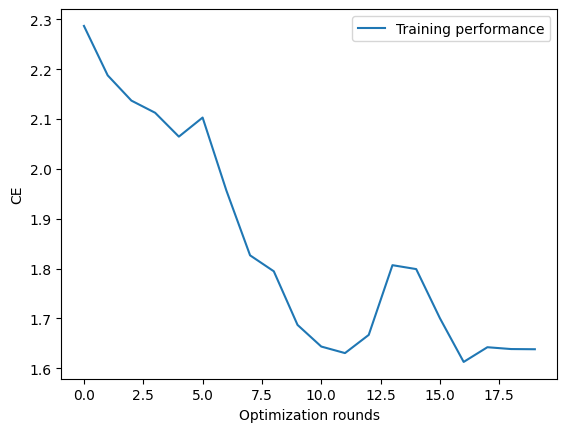

In [170]:
train_losses = [x[1] for x in res.metrics_distributed_fit['losses']]
plt.plot(train_losses, label='Training performance')
plt.legend()
plt.xlabel('Optimization rounds')
plt.ylabel('CE')
plt.show()

# Performance on test set

In [171]:
model_round = 20
net = MultiToOneRNN(hidden_size=hidden_size)
net.load_state_dict(torch.load(f'./model_round_{model_round}.pth'), strict=False)

<All keys matched successfully>

In [172]:
test_data = []
for i, consumer in enumerate(data):
    if i > 40:
        test_data += data[consumer]
test_loader = DataLoader(ClassificationData(test_data), batch_size=batch_size)

In [173]:
def test(net, test_loader):
    """Test the network on the test set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    num_layers = net.num_layers
    batch_size = test_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    net.eval()
    total_loss = 0.0
    golds = []
    preds = []
    for x, Y in tqdm(test_loader):
        Y = Y.to(DEVICE)
        x = x.to(DEVICE).view(x.shape[0], -1, 1)
        hidden = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        cell = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        outs, hidden, cell = net(x, hidden, cell)
        loss = criterion(outs[:, -1], Y)    
        total_loss += loss.item()
        pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
        preds += pred.tolist()
        golds += Y.tolist()
    val_losses.append(total_loss / len(test_loader))
    acc = np.mean((np.array(golds) == np.array(preds)))
    print(f' Test loss: {total_loss / len(test_loader)}, accuracy: {acc}')
    return val_losses, preds, golds

In [174]:
losses, preds, golds = test(net, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:02<00:00, 443.90it/s]

 Test loss: 2.1695336346487397, accuracy: 0.21800242865816635


In [175]:
from collections import Counter

In [176]:
count = Counter(preds)
count

Counter({8: 19089,
         1: 2453,
         4: 4227,
         5: 1191,
         6: 1428,
         7: 2287,
         3: 1675,
         0: 78,
         2: 512})

(DefaultActor pid=32132) /opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(DefaultActor pid=32132)   warnings.warn('resource_tracker: There appear to be %d '


In [179]:
matrix = confusion_matrix(golds, preds)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'Kettle'),
  Text(0, 1.5, 'Lighting'),
  Text(0, 2.5, 'Refrigerator'),
  Text(0, 3.5, 'Water heater'),
  Text(0, 4.5, 'Washing Machine'),
  Text(0, 5.5, 'Microwave'),
  Text(0, 6.5, 'TV'),
  Text(0, 7.5, 'Dryer'),
  Text(0, 8.5, 'AC'),
  Text(0, 9.5, 'Dish washer')])

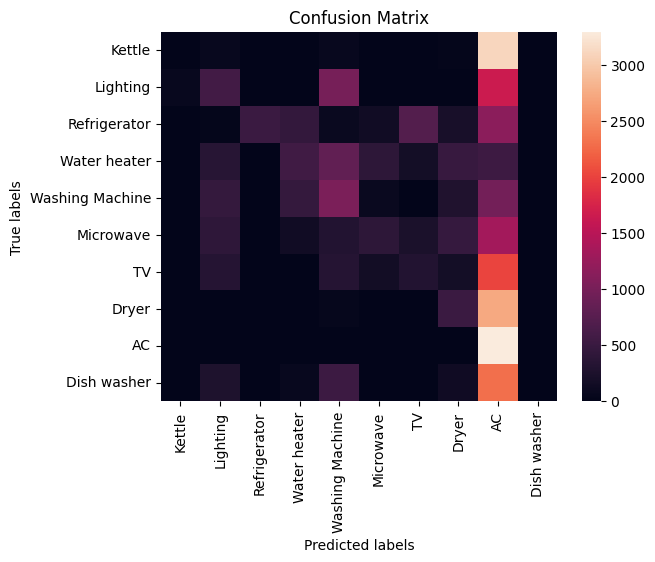

In [195]:
ax= plt.subplot()
sns.heatmap(matrix, annot=False, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(l2idx.keys())
ax.yaxis.set_ticklabels(l2idx.keys())
plt.xticks(rotation=90)
plt.yticks(rotation=0)